# Estimating Surface Diabatic Layer
Time averaging of a range of densities that outcrop

In [13]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [14]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.0efd5429ae874aa88d3627e980983935/status,


In [34]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
import json
import gsw
import fastjmd95

In [2]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
ds  = cat["CESM_POP_hires_control"].to_dask()

In [3]:
#assign each region index value to basin name

caspian_sea = -14
black_sea = -13
#unknown = -1
#unknown = 0
southern_ocean = 1
pacific_ocean = 2
indian_ocean = 3
persian_gulf = 4
red_sea = 5
atlantic_ocean = 6
med_sea = 7
lab_sea = 8
norwegian_sea = 9
arctic_ocean = 10
hudson_bay = 11
baltic_sea = 12

In [4]:
#combining atl, lab and norwegian sea masks together
nor_bool = ds.REGION_MASK.where(ds.REGION_MASK==9).notnull()
lab_bool = ds.REGION_MASK.where(ds.REGION_MASK==8).notnull()
atl_bool = ds.REGION_MASK.where(ds.REGION_MASK==6).notnull()

In [5]:
atl_mask = (nor_bool+lab_bool+atl_bool)

In [35]:
#define sigma0
rho = fastjmd95.rho(ds.SSS, ds.SST, 0).rename('rho')

In [41]:
delta_rho = 0.1
rho_bins = np.arange(1024, 1027, delta_rho)

# Split the view by basin

In [16]:
def basin_selection(da, basin):
    tendency_in_basin = da.where(ds.REGION_MASK==basin)
    return tendency_in_basin

In [54]:
southern = basin_selection(rho, southern_ocean)
ml_south = basin_selection((ds.HMXL_2*1e-2), southern_ocean)

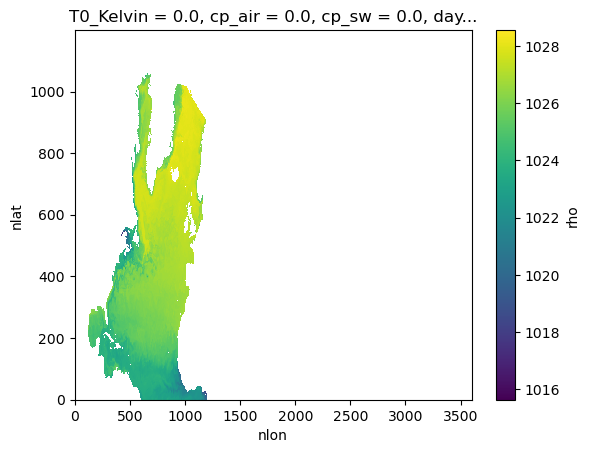

In [36]:
rho.where(atl_mask).isel(nlat=slice(1200, None))[0].plot()

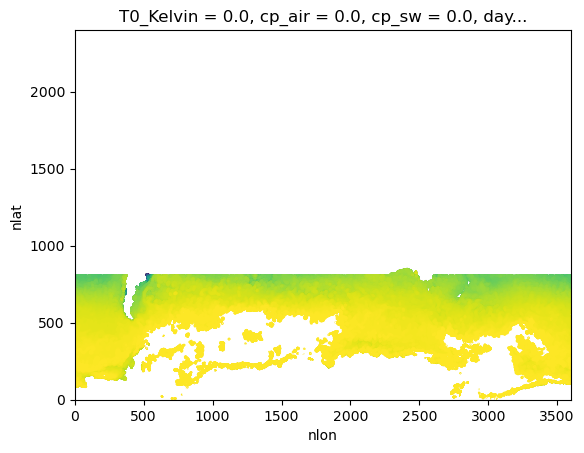

In [39]:
southern[0].plot.contour(levels=rho_bins)

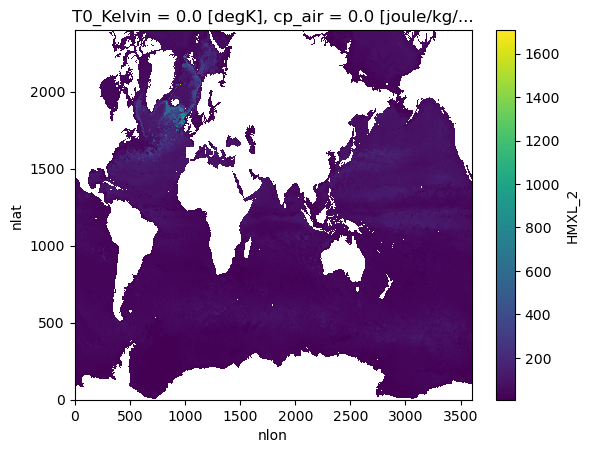

In [48]:
(ds.HMXL_2*1e-2)[0].plot()

In [51]:
rho_bins

array([1024. , 1024.1, 1024.2, 1024.3, 1024.4, 1024.5, 1024.6, 1024.7,
       1024.8, 1024.9, 1025. , 1025.1, 1025.2, 1025.3, 1025.4, 1025.5,
       1025.6, 1025.7, 1025.8, 1025.9, 1026. , 1026.1, 1026.2, 1026.3,
       1026.4, 1026.5, 1026.6, 1026.7, 1026.8, 1026.9])

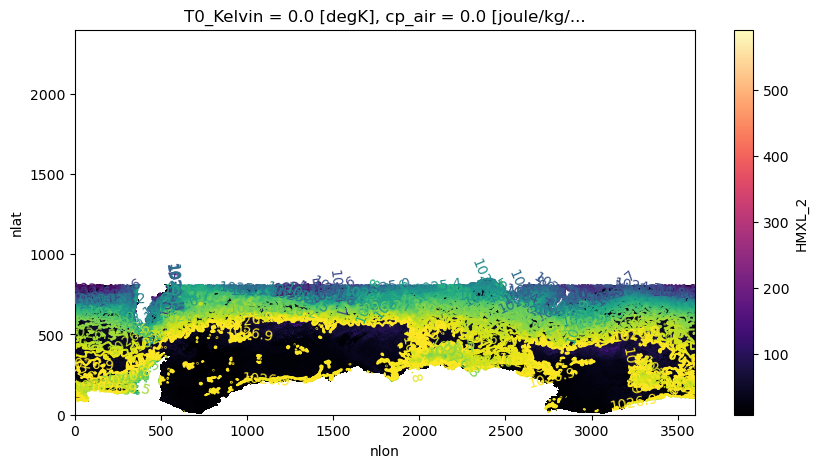

In [56]:
fig, ax = plt.subplots(figsize=(10,5))
C = southern[0].plot.contour(levels=rho_bins, ax=ax)
# makes first contour thicker and cyan, can do for contour line dividing bottom water (index 25 w current arange)
#C.collections[0].set_color('cyan') 
#C.collections[0].set_linewidth(3)
plt.clabel(C)
ml_south[0].plot(cmap='magma')